In [12]:
import numpy as np
from nn import nn, io, preprocess

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

import matplotlib as mpl
import matplotlib.pyplot as plt

In [13]:
architecture = [{'input_dim': 4000, 'output_dim': 500, 'activation': 'relu'}, 
                {'input_dim': 500, 'output_dim': 250, 'activation': 'relu'},
                {'input_dim': 250, 'output_dim': 50, 'activation': 'relu'},
                {'input_dim': 50, 'output_dim': 1, 'activation': 'sigmoid'}]
my_nn = nn.NeuralNetwork(nn_arch=architecture, lr=0.1, seed=42, batch_size=100, epochs=200, loss_function='bin_ce')

In [14]:
negatives = io.read_fasta_file('data/yeast-upstream-1k-negative.fa')
positives = io.read_text_file('data/rap1-lieb-positives.txt')

seqs, labels = preprocess.sample_seqs(negatives+positives, [False for _ in negatives] + [True for _ in positives])
seqs_1hot = np.array(preprocess.one_hot_encode_seqs(seqs))

labels = [1 if label=='True' else 0 for label in labels]
labels = np.array([labels]).T

In [15]:
# make splits
X_train, X_test, y_train, y_test = train_test_split(seqs_1hot, labels, test_size=0.3, random_state=42, shuffle=True, stratify=None)

In [16]:
# train model
per_epoch_loss_train, per_epoch_loss_val = my_nn.fit(X_train, y_train, X_test, y_test)

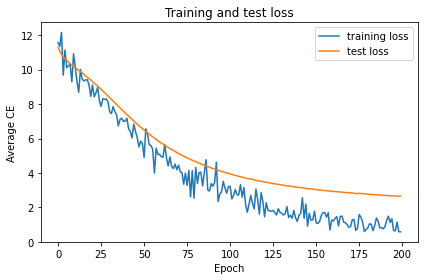

In [26]:
# plot training and test losses across epochs
plt.plot(per_epoch_loss_train)
plt.plot(per_epoch_loss_val)

plt.xlabel('Epoch')
plt.ylabel('Average CE')
plt.title('Training and test loss')
plt.legend(['training loss', 'test loss'])
plt.tight_layout()

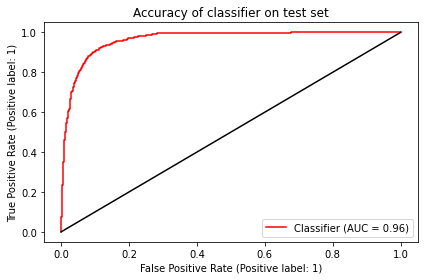

In [22]:
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=my_nn.predict(X_test), color='r')
plt.plot([0,1],[0,1],c='k')
plt.title('Accuracy of classifier on test set')
plt.tight_layout()

I chose to use a binary cross-entropy loss because this is a binary classification task, and the outputs of the model be interpreted as probabilities if the activation function of the output layer is a sigmoid (or otherwise bounded from 0 to 1). To choose hyperparameters, I started with a five-layer model that decreased the dimensions of the layers from 4000 to 1000 to 500 to 250 to 50 to 1, since decreasing by factors of 2, 4, or 5 seemed reasonable. I increased learning rate until I began to observe instability in the training loss and then increased the number of epochs and decreased the batch size until the training loss plateaued. I then experimented with decreasing the sizes and numbers of layers, since my training loss was very low but my test loss was very high. I found that decreasing the number and sizes of the layers increased the AUC for the test set with other hyperparameters held similar, so went with the current architecture and then repeated the cycle of tuning number of epochs and batch size.